# **Amtrak Ridership Regression-Based Forecasting Model**

# **Import Required Packages**

In [135]:
# Importing libraries
import math
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import statsmodels.formula.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa import tsatools, stattools
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics import tsaplots

# **Loading, Preprocessing and Splitting Data**

In [136]:
# Load, convert Amtrak data for time series analysis
Amtrak_df = pd.read_csv('Amtrak.csv')
Amtrak_df.head(9)
print(Amtrak_df)

          Month  Ridership
0    01/01/1991   1708.917
1    01/02/1991   1620.586
2    01/03/1991   1972.715
3    01/04/1991   1811.665
4    01/05/1991   1974.964
..          ...        ...
154  01/11/2003   2076.054
155  01/12/2003   2140.677
156  01/01/2004   1831.508
157  01/02/2004   1838.006
158  01/03/2004   2132.446

[159 rows x 2 columns]


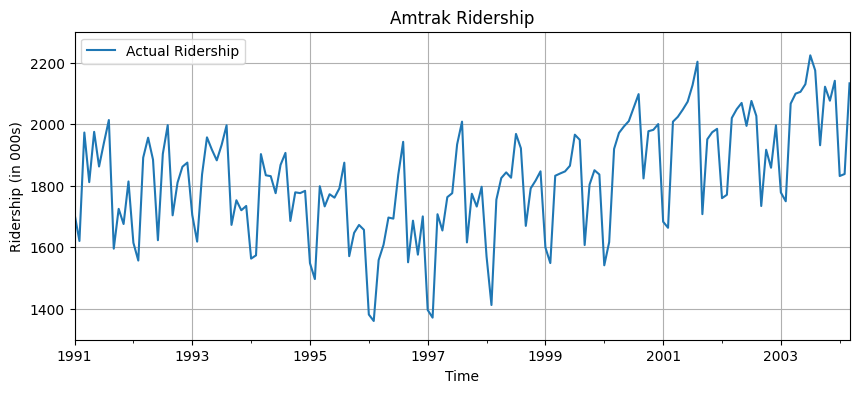

In [137]:
# Convert 'Month' to datetime and create time series
Amtrak_df['Date'] = pd.to_datetime(Amtrak_df['Month'], format='%d/%m/%Y')
ridership_ts = pd.Series(Amtrak_df['Ridership'].values, index=Amtrak_df['Date'])

# Add trend and constant to DataFrame
ridership_df = tsatools.add_trend(ridership_ts, trend='ct')
ridership_df['Ridership'] = ridership_ts.values  # add the actual series for modeling

# Fit linear regression model: Ridership ~ trend + constant
ridership_lm = smf.ols(formula='Ridership ~ trend', data=ridership_df).fit()

# Plot the time series
ax = ridership_ts.plot(label='Actual Ridership', figsize=(10, 4))
ax.set_xlabel('Time')
ax.set_ylabel('Ridership (in 000s)')
ax.set_ylim(1300, 2300)
ax.set_title('Amtrak Ridership')
ax.legend()
plt.grid(True)
plt.show()


### **Data Splitting**

In [138]:
# Split data: 120 training points, rest validation
train_df = ridership_df.iloc[:120]
valid_df = ridership_df.iloc[120:]

### **Linear Model**

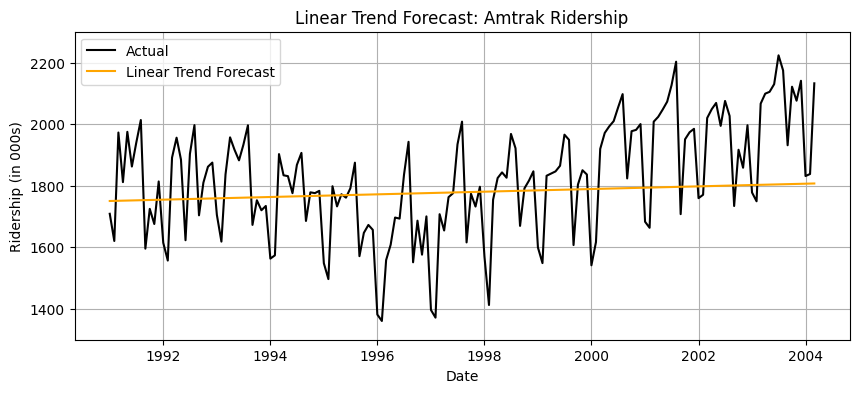

In [140]:
# Fit linear model on training data
ridership_lm = smf.ols(formula='Ridership ~ trend', data=train_df).fit()

# Predict on full dataset
all_predictions = ridership_lm.predict(ridership_df)

# Plot actual vs linear trend
plt.figure(figsize=(10, 4))
plt.plot(ridership_df.index, ridership_df['Ridership'], label='Actual', color='black')
plt.plot(ridership_df.index, all_predictions, label='Linear Trend Forecast', color='orange')
plt.xlabel('Date')
plt.ylabel('Ridership (in 000s)')
plt.title('Linear Trend Forecast: Amtrak Ridership')
plt.ylim(1300, 2300)
plt.legend()
plt.grid(True)
plt.show()


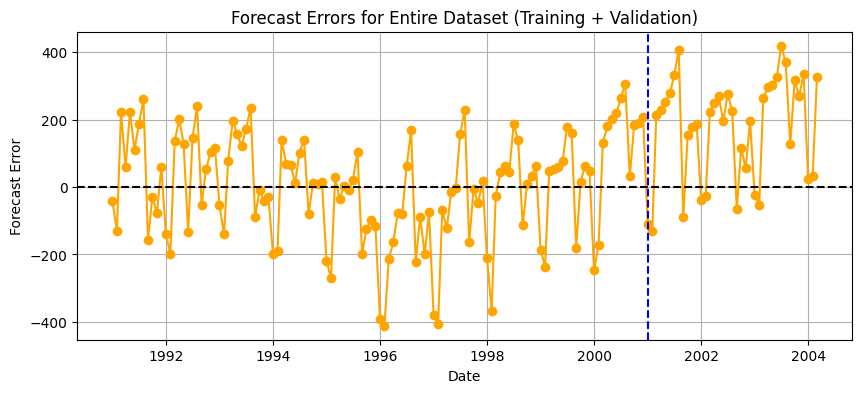

                            OLS Regression Results                            
Dep. Variable:              Ridership   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.7258
Date:                Thu, 10 Jul 2025   Prob (F-statistic):              0.396
Time:                        01:59:38   Log-Likelihood:                -778.50
No. Observations:                 120   AIC:                             1561.
Df Residuals:                     118   BIC:                             1567.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1750.0545     29.449     59.426      0.0

In [141]:
# Compute forecast errors (actual - predicted)
all_errors = ridership_df['Ridership'] - all_predictions

# Plot forecast errors
plt.figure(figsize=(10, 4))
plt.plot(ridership_df.index, all_errors, color='orange', marker='o', linestyle='-')
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Forecast Error')
plt.title('Forecast Errors for Entire Dataset (Training + Validation)')
plt.grid(True)

# Mark the training/validation cutoff
cutoff_date = ridership_df.index[nTrain]
plt.axvline(x=cutoff_date, color='blue', linestyle='--', label='Training/Validation Split')

plt.show()

# View summary
print(ridership_lm.summary())

# 📊 Interpretation

### 🔹 Intercept (1750.05)
This represents the estimated baseline ridership (in thousands) when the trend value is zero — essentially, the ridership at the starting point of the dataset.

It is highly statistically significant (p < 0.001), meaning this estimate is reliable.

### 🔹 Trend Coefficient (0.36)
This indicates that for each unit increase in the time trend (typically each month), ridership is expected to increase by 0.36 thousand passengers (i.e., 360 passengers).

However, the p-value is 0.396, which is not statistically significant (above the 0.05 threshold).

The 95% confidence interval [-0.477, 1.196] includes zero, further confirming that the trend effect is not significant.

---

### ✅ Conclusion:
While the baseline level of ridership is statistically strong, the trend over time is not significant, meaning there's no clear evidence of growth or decline in ridership based on this linear trend model.


### **Exponential Model**

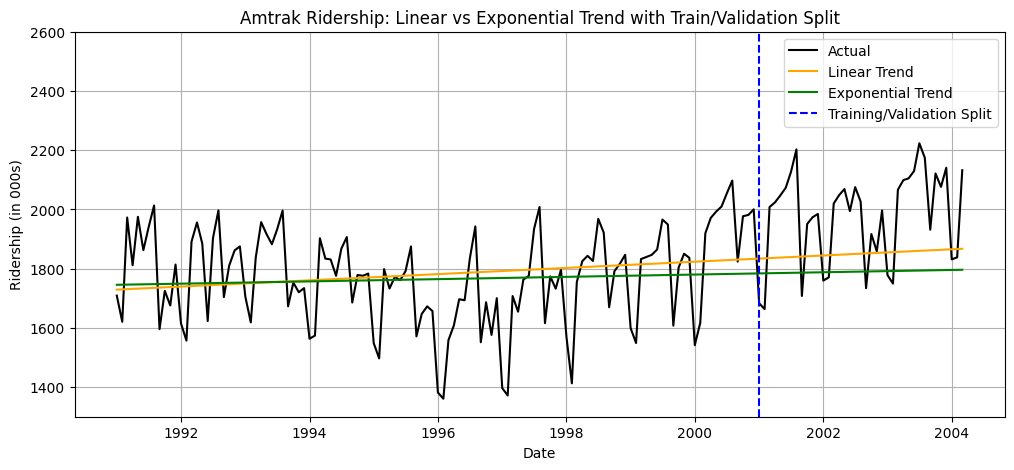

In [142]:
# Exponential model (log scale, then back-transform)
ridership_lm_expo = sm.ols(formula='np.log(Ridership) ~ trend', data=train_df).fit()
predict_log_expo_all = ridership_lm_expo.predict(ridership_df)
predict_expo_all = np.exp(predict_log_expo_all)

# Plot everything
plt.figure(figsize=(12, 5))

# Actual ridership
plt.plot(ridership_df.index, ridership_df['Ridership'], label='Actual', color='black')

# Linear trend forecast
plt.plot(ridership_df.index, predict_linear_all, label='Linear Trend', color='orange')

# Exponential trend forecast
plt.plot(ridership_df.index, predict_expo_all, label='Exponential Trend', color='green')

# Mark the training/validation cutoff
cutoff_date = ridership_df.index[nTrain]
plt.axvline(x=cutoff_date, color='blue', linestyle='--', label='Training/Validation Split')

# Final touches
plt.xlabel('Date')
plt.ylabel('Ridership (in 000s)')
plt.title('Amtrak Ridership: Linear vs Exponential Trend with Train/Validation Split')
plt.ylim(1300, 2600)
plt.legend()
plt.grid(True)
plt.show()

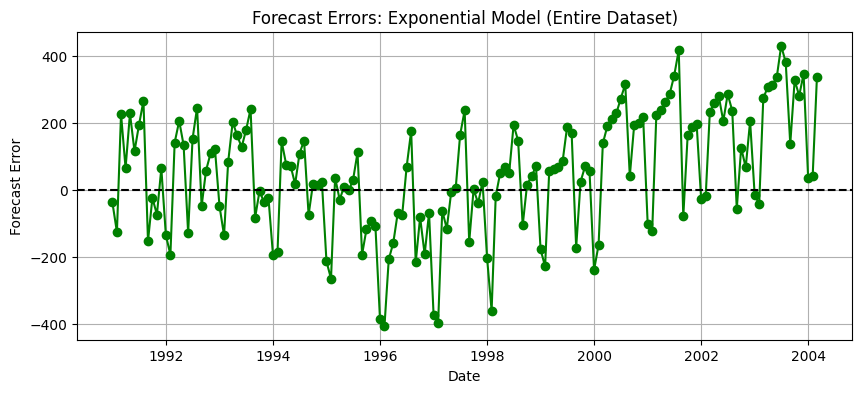

                            OLS Regression Results                            
Dep. Variable:      np.log(Ridership)   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.5448
Date:                Thu, 10 Jul 2025   Prob (F-statistic):              0.462
Time:                        01:59:58   Log-Likelihood:                 115.58
No. Observations:                 120   AIC:                            -227.2
Df Residuals:                     118   BIC:                            -221.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.4646      0.017    436.237      0.0

In [143]:
# Calculate forecast errors for exponential model (actual - predicted)
forecast_errors_expo = ridership_df['Ridership'] - predict_expo_all

# Plot forecast errors
plt.figure(figsize=(10, 4))
plt.plot(ridership_df.index, forecast_errors_expo, color='green', marker='o', linestyle='-')
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Forecast Error')
plt.title('Forecast Errors: Exponential Model (Entire Dataset)')
plt.grid(True)
plt.show()

# View summary
print(ridership_lm_expo.summary())


# 📊 Interpretation
---

### 🔹 Intercept (7.4646)
This is the estimated log of the baseline ridership when the trend is zero.

Exponentiating the intercept gives the baseline ridership in the original scale:

\[
e^{7.4646} \approx 1746.8 \text{ thousand passengers}
\]

This estimate is highly statistically significant (p < 0.001), indicating a reliable baseline ridership level.

### 🔹 Trend Coefficient (0.0002)
This coefficient represents the expected change in the **log** of ridership for each unit increase in the time trend (e.g., each month).

- Because the model is log-linear, the coefficient can be interpreted approximately as a **percentage change** in ridership per unit increase in trend:

\[
\text{Percentage change} \approx 0.0002 \times 100 = 0.02\%
\]

- However, the p-value is 0.462, which is not statistically significant (greater than 0.05).

- The 95% confidence interval includes zero, indicating the trend effect is uncertain and not statistically meaningful.

---

### ✅ Conclusion:
The baseline ridership (on the original scale) is estimated reliably at about 1.75 million passengers.

However, there is **no significant evidence of growth or decline** in ridership over time based on the exponential (log-linear) model.


### **Polynomial Model**

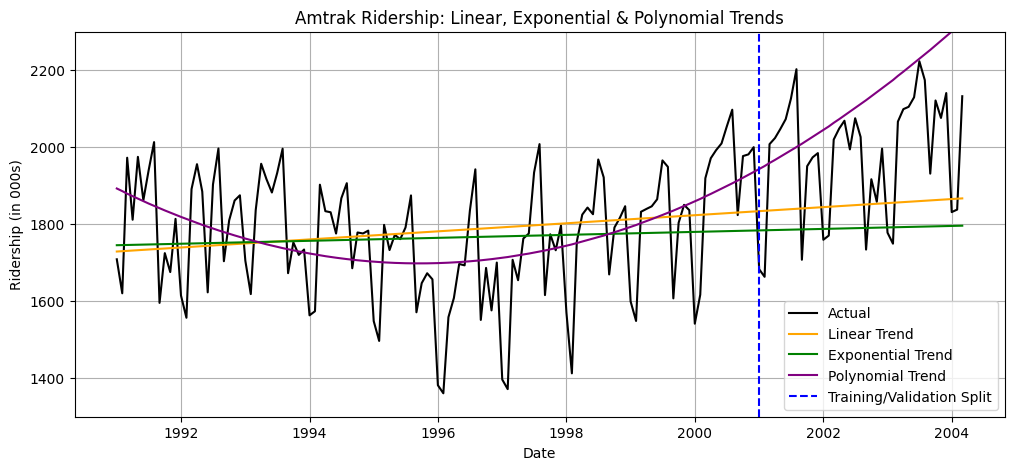

In [145]:
# Fit the polynomial (quadratic) trend model on training data
ridership_lm_poly = sm.ols(formula='Ridership ~ trend + np.square(trend)', data=train_df).fit()

# Predict on full dataset using the polynomial model
# Add squared trend term to full data
ridership_df['trend_squared'] = np.square(ridership_df['trend'])

# Predict using polynomial model
predict_poly_all = ridership_lm_poly.predict(ridership_df)

# Plot all models including polynomial
plt.figure(figsize=(12, 5))

# Actual ridership
plt.plot(ridership_df.index, ridership_df['Ridership'], label='Actual', color='black')

# Linear trend
plt.plot(ridership_df.index, predict_linear_all, label='Linear Trend', color='orange')

# Exponential trend
plt.plot(ridership_df.index, predict_expo_all, label='Exponential Trend', color='green')

# Polynomial trend
plt.plot(ridership_df.index, predict_poly_all, label='Polynomial Trend', color='purple')

# Train-validation cutoff
cutoff_date = ridership_df.index[nTrain]
plt.axvline(x=cutoff_date, color='blue', linestyle='--', label='Training/Validation Split')

# Final touches
plt.xlabel('Date')
plt.ylabel('Ridership (in 000s)')
plt.title('Amtrak Ridership: Linear, Exponential & Polynomial Trends')
plt.ylim(1300, 2300)
plt.legend()
plt.grid(True)
plt.show()

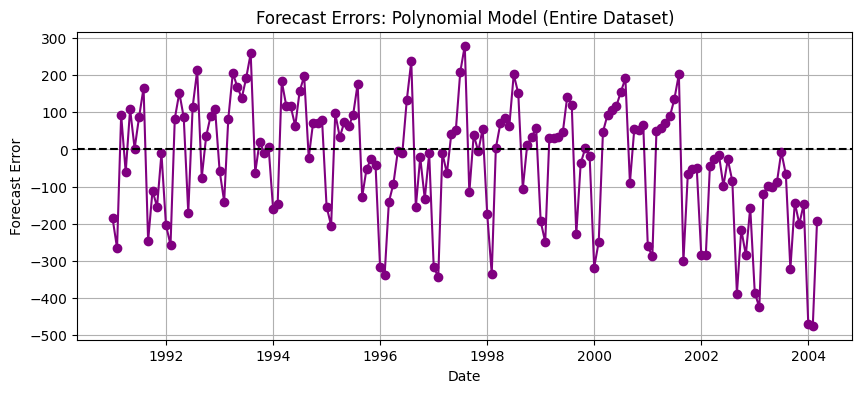

                            OLS Regression Results                            
Dep. Variable:              Ridership   R-squared:                       0.174
Model:                            OLS   Adj. R-squared:                  0.160
Method:                 Least Squares   F-statistic:                     12.31
Date:                Thu, 10 Jul 2025   Prob (F-statistic):           1.40e-05
Time:                        02:00:39   Log-Likelihood:                -767.41
No. Observations:                 120   AIC:                             1541.
Df Residuals:                     117   BIC:                             1549.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         1899.7695     40.872  

In [146]:
# Calculate forecast errors for polynomial model (actual - predicted)
forecast_errors_poly = ridership_df['Ridership'] - predict_poly_all

# Plot forecast errors
plt.figure(figsize=(10, 4))
plt.plot(ridership_df.index, forecast_errors_poly, color='purple', marker='o', linestyle='-')
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Forecast Error')
plt.title('Forecast Errors: Polynomial Model (Entire Dataset)')
plt.grid(True)
plt.show()

# View summary
print(ridership_lm_poly.summary())

# 📊 Interpretation        
---

### 🔹 Intercept (1899.77)
This is the estimated ridership (in thousands) at the starting point (when `trend = 0`). It reflects the baseline level and is **highly statistically significant** (p < 0.001).

### 🔹 Trend Coefficient (-7.00)
This negative coefficient suggests that initially, ridership decreases with time.

The **significant p-value (p < 0.001)** confirms that this declining effect is statistically meaningful.

### 🔹 Quadratic Term (trend² = 0.0609)
The positive and statistically significant (p < 0.001) quadratic term suggests that the rate of decline slows down and eventually **reverses into growth**.

This curvature indicates a **U-shaped trend**, where ridership first drops, then rises over time.

---

### 📈 Model Interpretation Summary:
- The **polynomial model fits better** than the linear or exponential models, with **R² = 0.174**, indicating that about 17.4% of the variation in ridership is explained by the model.
- The trend over time is **nonlinear**: there’s an initial drop in ridership followed by a recovery.

---




## **Seasonal Model**

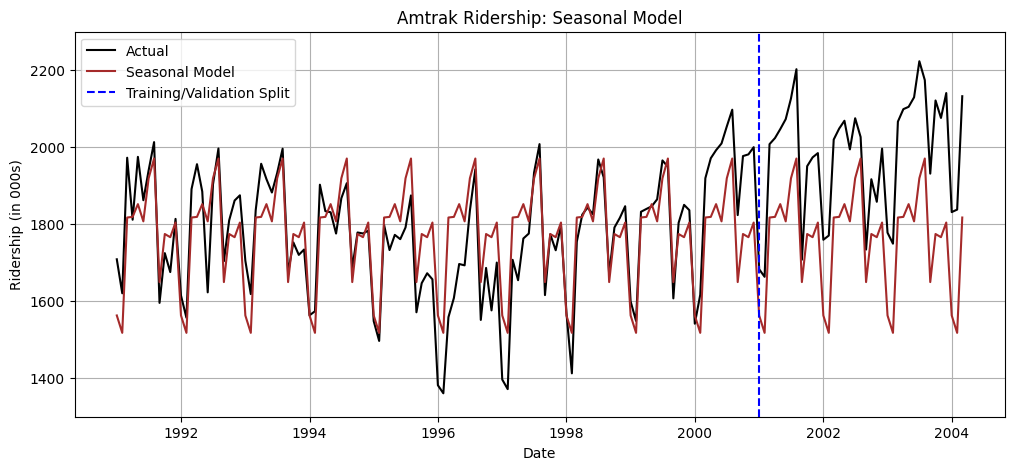

In [147]:
# Add constant trend (just intercept) — no time trend this time
ridership_df = tsatools.add_trend(ridership_ts, trend='c')

# Add 'Month' column for seasonality (categorical)
ridership_df['Month'] = ridership_df.index.month

# Add 'Ridership' values again to use in regression
ridership_df['Ridership'] = ridership_ts.values

# Split into train and validation sets
nTrain = 120
train_df = ridership_df.iloc[:nTrain]
valid_df = ridership_df.iloc[nTrain:]

# Fit seasonal model using dummy variables for Month
ridership_lm_season = sm.ols(formula='Ridership ~ C(Month)', data=train_df).fit()

# Predict on full dataset
predict_season_all = ridership_lm_season.predict(ridership_df)

# Plot all models including seasonal
plt.figure(figsize=(12, 5))

# Actual ridership
plt.plot(ridership_df.index, ridership_df['Ridership'], label='Actual', color='black')

# Seasonal model
plt.plot(ridership_df.index, predict_season_all, label='Seasonal Model', color='brown')

# Train-validation split line
plt.axvline(x=ridership_df.index[nTrain], color='blue', linestyle='--', label='Training/Validation Split')

# Labels and legend
plt.xlabel('Date')
plt.ylabel('Ridership (in 000s)')
plt.title('Amtrak Ridership: Seasonal Model')
plt.ylim(1300, 2300)
plt.legend()
plt.grid(True)
plt.show()

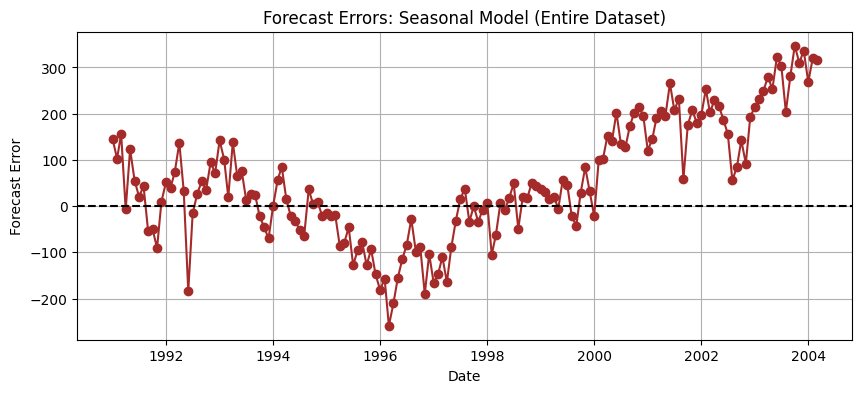

                            OLS Regression Results                            
Dep. Variable:              Ridership   R-squared:                       0.647
Model:                            OLS   Adj. R-squared:                  0.611
Method:                 Least Squares   F-statistic:                     18.01
Date:                Thu, 10 Jul 2025   Prob (F-statistic):           8.13e-20
Time:                        02:01:25   Log-Likelihood:                -716.36
No. Observations:                 120   AIC:                             1457.
Df Residuals:                     108   BIC:                             1490.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       1563.0546     31.568     49.

In [149]:
# Compute forecast errors for all data
all_errors_season = ridership_df['Ridership'] - predict_season_all

# Plot forecast errors
plt.figure(figsize=(10, 4))
plt.plot(ridership_df.index, all_errors_season, color='brown', marker='o', linestyle='-')
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Forecast Error')
plt.title('Forecast Errors: Seasonal Model (Entire Dataset)')
plt.grid(True)
plt.show()


# View summary
print(ridership_lm_season.summary())

# 📊 Interpretation
---
### 🔹 Intercept (1563.05)
- Baseline ridership (in thousands) for **January**, when all dummy variables are zero.
- Highly significant (p < 0.001).

### 🔹 Monthly Effects (relative to January)
- **March–August** show **large, significant increases** (peaking in August at +407.58 k).
- **February** shows a non‑significant decrease (–45.25 k, p = 0.313).
- **September** is marginal (p = 0.055) and may not differ from January.
- **October–December** all show significant positive differences.

---

### ✅ Model Fit
- **R² = 0.647, Adj. R² = 0.611**: 64.7% of training variation explained.
- **F‑statistic = 18.01, p < 0.0001**: Model is highly significant overall.
- Seasonal dummies capture strong month‑to‑month variation; adding a trend term (if desired) could further refine long‑term direction.

---


### **Combined Trend and Seasonal Model**

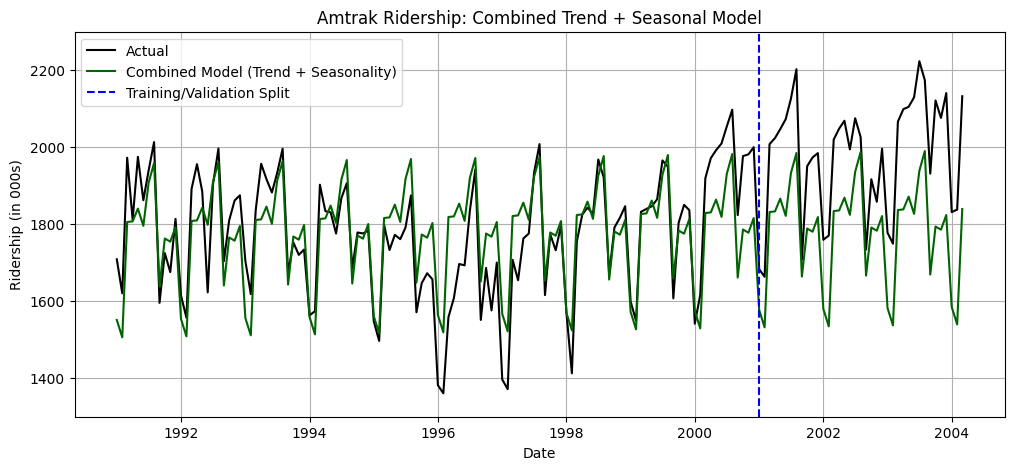

                            OLS Regression Results                            
Dep. Variable:              Ridership   R-squared:                       0.649
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     16.51
Date:                Thu, 10 Jul 2025   Prob (F-statistic):           2.60e-19
Time:                        02:01:59   Log-Likelihood:                -715.99
No. Observations:                 120   AIC:                             1458.
Df Residuals:                     107   BIC:                             1494.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       1551.4031     34.700     44.

In [150]:
# Add linear trend column to ridership_df (if not already present)
# We'll create a numeric time index as the trend variable
ridership_df['trend'] = np.arange(len(ridership_df))

# Split train and validation sets again (to keep consistent)
train_df = ridership_df.iloc[:nTrain]
valid_df = ridership_df.iloc[nTrain:]

# Fit combined model: Ridership ~ trend + seasonality (Month)
ridership_lm_combined = sm.ols(formula='Ridership ~ trend + C(Month)', data=train_df).fit()

# Predict on the full dataset
predict_combined_all = ridership_lm_combined.predict(ridership_df)

# Plot actual ridership and combined model predictions
plt.figure(figsize=(12, 5))

plt.plot(ridership_df.index, ridership_df['Ridership'], label='Actual', color='black')
plt.plot(ridership_df.index, predict_combined_all, label='Combined Model (Trend + Seasonality)', color='darkgreen')

plt.axvline(x=ridership_df.index[nTrain], color='blue', linestyle='--', label='Training/Validation Split')

plt.xlabel('Date')
plt.ylabel('Ridership (in 000s)')
plt.title('Amtrak Ridership: Combined Trend + Seasonal Model')
plt.ylim(1300, 2300)
plt.legend()
plt.grid(True)
plt.show()

# View summary of combined model
print(ridership_lm_combined.summary())


# 📊 Interpretation

---

### 🔹 Intercept (1551.40)
- Estimated ridership (in thousands) for **January** at trend = 0 (start of dataset).
- Highly statistically significant (p < 0.001).
  
### 🔹 Monthly Effects (relative to January)
- Months **March to August** show large, significant positive ridership increases (e.g., August +406k passengers).
- February shows a non-significant decrease (~–45k, p=0.312).
- September shows a positive but marginally non-significant increase (p=0.06).
- October to December also show significant increases.
  
### 🔹 Trend Coefficient (0.22)
- Indicates an estimated increase of ~220 passengers per unit increase in time (likely monthly).
- However, the trend is **not statistically significant** (p = 0.417).
- The confidence interval [-0.31, 0.74] includes zero, so the model provides **no clear evidence of a linear upward or downward trend** beyond seasonality.

---

### ✅ Model Fit and Diagnostics
- **R-squared = 0.649** and **Adjusted R-squared = 0.610**: About 61–65% of variation in ridership is explained by this model.
- **F-statistic = 16.51**, p-value << 0.001: Model is statistically significant overall.
- **Durbin-Watson = 0.40**: Indicates potential positive autocorrelation of residuals (values close to 2 are ideal).
- Omnibus and Jarque-Bera tests suggest residuals are approximately normally distributed.

---

### 📌 **Summary:**
- The **strong seasonal pattern dominates the variation** in ridership.
- There is **no significant linear trend** detected after accounting for seasonality.
- Model effectively captures monthly ridership differences but may need refinement to address residual autocorrelation or explore non-linear trends.

---
